In [1]:
#automatically reload stuff
%load_ext autoreload
%autoreload 2

In [2]:
import Utils
import matplotlib.pyplot as plt
from SpatialPreprocessing import *
import pprint
import Formatting
from Constants import Const
import Models

In [ ]:
#read in the organ info and save it to a default format

# spatial_files = load_spatial_files()
# od = CamprtOrganData()
# pdict = od.process_cohort_spatial_dict(spatial_files)
# np_dict_to_json(pdict,Const.processed_organ_json)
# pprint.PrettyPrinter().pprint(pdict)
# del pdict

In [3]:
#this will be the format of the future data that is assumed for other functions
#before transforming them into usable arrays
#currently missing values are Nan.  Organs preserves the order in other arrays
pdata = load_pdict()
pdata 

{'organs': ['Bone_Hyoid',
  'Bone_Mastoid_L',
  'Bone_Mastoid_R',
  'Brachial_Plex_L',
  'Brachial_Plex_R',
  'Brainstem',
  'Cartlg_Thyroid',
  'Cricoid',
  'Cricopharyngeus',
  'Esophagus_U',
  'Glnd_Submand_L',
  'Glnd_Submand_R',
  'Glottic_Area',
  'Hardpalate',
  'Larynx',
  'Larynx_SG',
  'Lips_Lower',
  'Lips_Upper',
  'Mandible',
  'Musc_Constrict_I',
  'Musc_Constrict_M',
  'Musc_Constrict_S',
  'Musc_Geniogloss',
  'Musc_Masseter_L',
  'Musc_Masseter_R',
  'Musc_Sclmast_L',
  'Musc_Sclmast_R',
  'Oral_Cavity',
  'Palate_Soft',
  'Parotid_L',
  'Parotid_R',
  'Pterygoid_Lat_L',
  'Pterygoid_Lat_R',
  'Pterygoid_Med_L',
  'Pterygoid_Med_R',
  'SpinalCord_Cerv',
  'Tongue'],
 'patients': {'3': {'GTVp': {'volume': 13.1,
    'mean_dose': 71.9,
    'centroids': [295.3126, 226.5868, 77.6118],
    'distances': [15.25,
     17.140625,
     81.375,
     10.515625,
     44.90625,
     39.125,
     7.8125,
     17.75,
     20.859375,
     36.53125,
     0.9765625,
     47.625,
     32.2

In [5]:
#so this should check that the values make sense
#currently it implies there is an issue but I don't know what
def get_num_nans_per_organ(sdata):
    #should return a list of the % of patients missing data for each organ
    #for each entry type
    olist = sdata['organs']
    oarlist = olist + ['gtv']
    allnan = {}
    for key in ['distances','volume','centroids','mean_dose']:
        nancount = {o: 0 for o in oarlist}
        arr = Formatting.merged_spatial_array(sdata, key)
        for i,aa in enumerate(arr):
            #find missing organs for individual
            all_nan = np.argwhere(np.isnan(aa).all(axis=1))
            nanset = set([])
            if len(all_nan) < 1:
                continue
            for arg in all_nan[0]:
                nanorgan = oarlist[arg]
                nancount[nanorgan] = nancount[nanorgan] + 1
        nancount = [(k,np.round(100*nancount[k]/arr.shape[0],4)) for k,v in nancount.items() if v > 0]
        nancount = sorted(nancount, key = lambda x: -x[1])
        
        allnan[key] = nancount
    return allnan
get_num_nans_per_organ(pdata)

{'distances': [('Musc_Masseter_L', 95.0226),
  ('Brachial_Plex_R', 1.3575),
  ('Cricoid', 1.3575),
  ('Brainstem', 0.905),
  ('Bone_Mastoid_L', 0.4525),
  ('Bone_Mastoid_R', 0.4525),
  ('Hardpalate', 0.4525)],
 'volume': [('Musc_Masseter_L', 49.7738),
  ('Bone_Hyoid', 46.1538),
  ('Brachial_Plex_R', 1.3575),
  ('Brainstem', 0.905),
  ('Cricoid', 0.905),
  ('Bone_Mastoid_L', 0.4525),
  ('Cartlg_Thyroid', 0.4525)],
 'centroids': [('Musc_Masseter_L', 95.0226),
  ('Brachial_Plex_R', 1.3575),
  ('Cricoid', 1.3575),
  ('Brainstem', 0.905),
  ('Bone_Mastoid_L', 0.4525),
  ('Bone_Mastoid_R', 0.4525),
  ('Hardpalate', 0.4525)],
 'mean_dose': [('Musc_Masseter_L', 49.3213),
  ('Bone_Hyoid', 46.6063),
  ('Brachial_Plex_R', 1.3575),
  ('Brainstem', 0.905),
  ('Cricoid', 0.905),
  ('Bone_Mastoid_L', 0.4525),
  ('Cartlg_Thyroid', 0.4525)]}

In [12]:
#converts the json to a dictionary of arrays with all missing values imputed
#denoise alpha is the coefficient of how much of the densising is done 
#using the autoencoder used to input missing values [0 = none, 1 = all]
di = Formatting.DataInputer(denoise_alpha = .8)
ddict = di.get_formatted_arrays(pdata,retrain=False)
[(k,v.shape) for k,v in ddict.items()]

tensor(0.0225, grad_fn=<MeanBackward0>)


[('distances', (221, 38, 37)),
 ('distances_missing', (221, 38, 37)),
 ('volume', (221, 38, 1)),
 ('volume_missing', (221, 38, 1)),
 ('centroids', (221, 38, 3)),
 ('centroids_missing', (221, 38, 3)),
 ('mean_dose', (221, 38, 1)),
 ('mean_dose_missing', (221, 38, 1))]

In [11]:
#check the error on the neural net for inputing/denoising
#only considers non-missing values
di.error_report()

_mean_reconstruction_error (%)  mean_denoised  std_denoised  \
key                                                                      
distances                        3.903562       42.16431      34.69873   
volume                          19.362758       18.70465      26.93340   
centroids                        1.659513      170.07040      86.04279   
mean_dose                        6.125781       39.47673      19.41581   

          shape_denoised  num_nan_denoised  mean_original  std_original  \
key                                                                       
distances  (221, 38, 37)                 0       44.51535      34.20298   
volume      (221, 38, 1)                 0       19.32192      27.52120   
centroids   (221, 38, 3)                 0      174.67760      82.16222   
mean_dose   (221, 38, 1)                 0       41.03993      19.42796   

          shape_original  num_nan_original  
key                                         
distances  (221, 38, 37)             19102  
volume      (221, 38, 1)              4031  
centroids   (221, 38, 3)               786  
mean_dose   (221, 38, 1)              4067

In [ ]:
#takes in a dictionary of arrays (as in the DataInputer output
#returns a similarity matrix 0-1
#n_jobs > 1 will try to multithread
sim = Models.TssimSimilarity(n_jobs = 1)
sim_matrix = sim.get_similarity_matrix(ddict)
plt.imshow(sim_matrix)

In [ ]:
#takes a similarity matrix and returns a list of the indices of the nearest neighbors
#in order
knn = Models.PatientKNN(match_type = 'default', default_n_matches = 5)
knn_matches = knn.get_matches(sim_matrix)
knn_matches

In [ ]:
pdata['organs']

In [77]:
import sklearn.manifold as manifold
from shapely.geometry import Polygon,MultiPolygon
def slice_ddict(pdata, ddict, organs = None):
    if organs is None:
        return {k:v for k,v in ddict.items()}
    olist = pdata['organs']
    indx = [olist.index(o) for o in organs]
    new_dict = {}
    for k,v in ddict.items():
        new_val = v[:,indx + [-1],:]
        if 'distance' in k:
            new_val = new_val[:,:,indx]
        new_dict[k] = new_val
    return new_dict

def radius_from_volume(v, eps = .01):
    if v < eps:
        v = eps
    return (v*3/(4))**(1/3)

def getSphereSize(npoints):
    slices = int(np.sqrt(npoints))
    stops = int(np.ceil(npoints/slices))
    return slices, stops

def sphere3d(center, radius, npoints):
    slices, stops = getSphereSize(npoints)
    #will not necessarily b npoints because its weird
    pcloud = np.empty((slices*stops, 3))
    pcloud[:] = center
    theta_rotation = 2*np.pi/stops
    phi_rotation = np.pi/slices
    phi = 0
    count = 0
    for i in range(slices):
        theta = 0
        phi_vec = np.array([np.sin(phi),np.sin(phi),np.cos(phi)])
        for ii in range(stops):
            theta_vec = np.array([np.cos(theta),np.sin(theta), 1])
            vector = radius * (theta_vec * phi_vec)
            pcloud[count] += vector
            theta += theta_rotation
            count += 1
        phi += phi_rotation
    return pcloud
            

def sphere2d(center, radius, npoints):
    pcloud = np.empty((npoints, 2))
    pcloud[:] = center
    rotation = 2*np.pi/(npoints)
    angle = 0
    for idx in range(npoints):
        vector = [np.cos(angle), np.sin(angle)]
        pcloud[idx] += radius*np.array(vector)
        angle += rotation
    return pcloud

def make_pointcloud(centroid, volume,npoints):
    #shape (ndim,) = (3,) (1,) (norgans,)
    radius = radius_from_volume(volume[0])
    ndims = centroid.shape[0]
    if ndims == 2:
        return sphere2d(centroid,radius,npoints)
    else:
        return sphere3d(centroid,radius,npoints)
    
def make_organset_pointcloud(centroids, volume, distances,npoints):
    #n_organs x n_dim shaped inputs
    n_organs = centroids.shape[0]
    pclouds = []
    for oidx in range(n_organs):
        try:
            organ_pcloud = make_pointcloud(centroids[oidx],
                                           volume[oidx],
                                           npoints)
            pclouds.append(organ_pcloud)
        except Exception as e:
            print('error making single pcloud',e)
            
    pclouds = np.stack(pclouds)
    return pclouds

def polygon_shape_error(pgon,vol,centroid,alpha = .1, beta = 1):
    vol_err = np.abs((vol[0] - pgon.area))/(vol[0])
    center = [pgon.centroid.x,pgon.centroid.y]
    c_err = np.linalg.norm(center - centroid)
    return alpha*vol_err + beta*c_err

def pcloud_loss(pcloud,vols,centroids,dists,vweight=.01,cweight=.5,dweight=1):
    #n_organs + 1 x ndim shaped arrays
    #pcloud (x npoints x ndim), vol (x1), centroids (x ndim) dists(x norgans)
    err = 0
    norgans = dists.shape[1]
    pgons = [Polygon(pc) for pc in pcloud]
    for i,pgon in enumerate(pgons):
        shape_err = polygon_shape_error(pgon,vols[i],centroids[i],vweight,cweight)
        d_err = 0
        for odist, pgon2 in zip(dists[i],pgons):
            d_err += np.abs((pgon.distance(pgon2) - odist)/odist)
        d_err *= dweight/(len(pgons) - 1)
    return d_err + shape_err

def get_starter_pointclouds(pdata, ddict,organs=None,ndim = 2,npoints = None):
    #should in-theory generate an array of polygons for each organ
    #based around centroid
    d = slice_ddict(pdata,ddict, organs)
    pointclouds = []
    n_patients = ddict['centroids'].shape[0]
    vols = d['volume']
    centroids = d['centroids']
    dists = d['distances']
    #do pca to reduce from 3 to 2 dimensions
    assert(ndim in [2,3])
    
    #double check I did this right later
    centroids = centroids - centroids.mean(axis=1).mean(axis=0)
    #so I should probabl do some unit analysis here
    vols = 10*vols.clip(min=.1)#/vols.max(axis=0)
    dists = dists.clip(min=.1)
    if ndim == 2:
        #so this should maybe be somehting idk
        centroids = centroids[:,:,0:2]
#         cshape = centroids.shape
#         c = centroids.reshape((-1,3))
#         print('staring mds')
#         c = manifold.Isomap().fit_transform(c)
#         print('finished')
#         centroids = c.reshape((cshape[0],cshape[1],ndim))
    if npoints is None:
        npoints = 10**(ndim-1)
    for idx in range(n_patients):
        try:
            pcloud = make_organset_pointcloud(centroids[idx],vols[idx],dists[idx],npoints)
            pointclouds.append(pcloud)
        except Exception as e:
            print('error making pointcloud')
            print(e)
    #will be n_patients, n_organs, n_points, n_dimensions
    #so output[x] will be a multipolygon for a patient 
    #and output[x,y] will be a pointcloud for an organ
    return np.stack(pointclouds)
        
#for some reason the masseter is alway way out there
test_organs = [o for o in pdata['organs']]# if "Masset" not in o]
pcs = get_starter_pointclouds(pdata,ddict, ndim = 2,organs=test_organs)

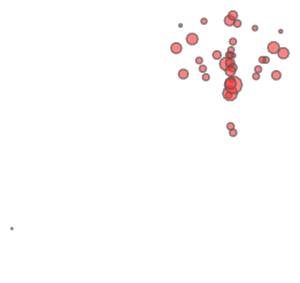

In [76]:
MultiPolygon([Polygon(p) for pc in pcs[6:7] for p in pc])

In [ ]:
def unstack(ndarr,dims=1):
    nshape = ndarr.shape
    newshape = [-1]
    curridx = dims
    while curridx < ndarr.ndim:
        newshape.append(nshape[curridx])
        curridx += 1
    return ndarr.reshape(tuple(newshape))

c = ddict['centroids'][:,oidx,0:ndim]
c = c - c.mean(axis=1).mean(axis=0)

for i in range(c.shape[0]):
    for ii in range(c.shape[1]):
        if np.lina

In [183]:
from inspect import getmembers, isfunction
import point_cloud_utils as pcu
print(getmembers(pcu, isfunction))

[('chamfer_distance', <function chamfer_distance at 0x000001BED26AF158>), ('contextmanager', <function contextmanager at 0x000001BE8E62EF28>), ('downsample_point_cloud_voxel_grid', <function downsample_point_cloud_voxel_grid at 0x000001BED26AF730>), ('hausdorff_distance', <function hausdorff_distance at 0x000001BED25AEC80>), ('interpolate_barycentric_coords', <function interpolate_barycentric_coords at 0x000001BED26AF7B8>), ('load_mesh_v', <function load_mesh_v at 0x000001BED268DD08>), ('load_mesh_vc', <function load_mesh_vc at 0x000001BED268DEA0>), ('load_mesh_vf', <function load_mesh_vf at 0x000001BED268DD90>), ('load_mesh_vfn', <function load_mesh_vfn at 0x000001BED26AF048>), ('load_mesh_vfnc', <function load_mesh_vfnc at 0x000001BED26AF0D0>), ('load_mesh_vn', <function load_mesh_vn at 0x000001BED268DE18>), ('load_mesh_vnc', <function load_mesh_vnc at 0x000001BED268DF28>), ('load_triangle_mesh', <function load_triangle_mesh at 0x000001BED268DC80>), ('pairwise_distances', <function p

In [204]:
import torch.nn as nn
import torch
import point_cloud_utils as pcu
from Pytorchtools import EarlyStopping
class PointCloudOptimizer(nn.Module):
    
    def __init__(self,
                 norgans,
                 ndim = 2,
                 npoints = 10,
                 hidden_dims = [1000]
                ):
        super(PointCloudOptimizer,self).__init__()
        self.ndim = ndim
        #I have to change the point size to work with spheres evenly
        self.npoints = npoints
        if ndim == 3: 
            i,ii = getSphereSize(npoints)
            self.true_npoints = ii*i
        else:
            self.true_npoints = npoints
        self.norgans = norgans
        self.pcloud_size = int(ndim*npoints)
        input_organ_size = self.pcloud_size + norgans + ndim + 1
        layers = [ nn.Linear(norgans*input_organ_size,hidden_dims[0]) ]
        for i in range(0,len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
            layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            
        self.output_shape = (norgans,npoints,ndim)
        layers.append(nn.Linear(hidden_dims[-1], norgans*npoints*ndim))
        self.layers = nn.Sequential( *layers )
#         self.layers.apply(self.init_weights)
        
    def init_weights(self,layer):
        #make the transform weights zero to start
        #so the output is always a valid polygon when it starts
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight,mean=0.0,std=0.0)
        
    def make_pclouds(self,x):
        #takes an entry from the centroid, volumes and distances of a patient
        #converts from numpy to torch also
        #c (centroids): norgans x ndim, 
        #v (volume): norgans x 1, 
        #d (distances) norgans x norgans
        [cs,vs,ds] = [i.cpu().detach().numpy() for i in x]
        pclouds = [make_organset_pointcloud(c,v,d,self.npoints) for c,v,d in zip(cs,vs,ds)]
        return torch.tensor(pclouds,requires_grad=True).float()
        
    def forward(self,x):
        # x is a list [c,v,d] of np arrays
        #c (centroids): len x norgans x ndim, 
        #v (volume): len x norgans x 1, 
        #d (distances) len x norgans x norgans
        
        #makes torch friendly
        #shape len x norgans x true_npoints x ndim
        pointclouds = self.make_pclouds(x)
        pc_shape = pointclouds.shape
        #reshape so it can concatenate with other inputs
        pointclouds = pointclouds.reshape((pc_shape[0],pc_shape[1],-1))
        #now is len x norgans x norgans + ndim + (npoints*ndim)
        out = torch.flatten(torch.cat([pointclouds] + x,dim=2),start_dim=1)
        out = self.layers(out).reshape(pc_shape)
        pointclouds = pointclouds.reshape(pc_shape)
        return out + pointclouds, pointclouds
        
def torch_pcloud_loss(ypred,ydefault,distances, a = 1, b = 1, 
                      max_neighbor_dist = 50):
    similarity_loss = nn.functional.mse_loss(ypred,ydefault)
    dist_loss = torch.tensor([0]).float()
    count = 0
    for i in range(ypred.shape[0]):
        for ii in range(ypred.shape[1]):
            target = ypred[i,ii].cpu().detach().numpy()
            for iii in range(ypred.shape[1]):
                original_dist = distances[i,ii,iii]
                if original_dist > max_neighbor_dist:
                    continue
                sink = ypred[i,iii].cpu().detach().numpy()
                min_dist = np.sqrt(pcu.pairwise_distances(target,sink).min())
                original_dist = distances[i,ii,iii]
                #penalize futher aw
                dloss = ((min_dist - original_dist)**2)/(original_dist**2)
                dist_loss += dloss
                count += 1
    dist_loss /= count
    return a*similarity_loss + b*dist_loss

def train_pcloud_optimizer(ddict, 
                        ndim = 2,
                        model_path = Const.pytorch_model_dir + 'pcloud.pt',
                        epochs = 100,
                        lr = .01
                        ):
    oidx = [i for i,o in enumerate(pdata['organs'])]# if "Masset" not in o]
    v = ddict['volume'][:,oidx].clip(min=.1)
    d = ddict['distances'][:,oidx]
    d = d[:,:,oidx].clip(min=.1)
    c = ddict['centroids'][:,oidx,0:ndim]
    c = c - c.mean(axis=1).mean(axis=0)
    c,v,d = [torch.tensor(i).float() for i in [c,v,d]]

    popt = PointCloudOptimizer(c.shape[1],ndim)
    early_stopping = EarlyStopping(patience = 20, path = model_path)
    torch_pcloud_loss(ypred,ydefault,d)
    optimizer = torch.optim.Adam(popt.parameters(),lr =lr)
    loss_hist = []
    for epoch in range(epoch):
        optimizer.zero_grad()
        ypred, ydefault = popt([c,v,d])
        loss = torch_pcloud_loss(ypred,ydefault,d)
        loss.backward()
        loss_hist.append(loss.item())
        print('epoch',epoch,loss.item())
        optimizer.step()
        torch.cuda.empty_cache()
        early_stopping(loss.item(),popt)
        if early_stopping.early_stop:
            print('early stop on epoch',epoch)
            break
    popt.load_state_dict(torch.load(model_path))
    plt.plot(loss_hist)
    return popt, loss_hist
popt, lh = train_pcloud_optimizer(ddict)

epoch 0 384322.75
epoch 1 10005808.0
epoch 2 42423468.0
epoch 3 11646401.0
epoch 4 599322.3125
epoch 5 8589972.0
epoch 6 4586863.5
epoch 7 354862.75


KeyboardInterrupt: 

In [ ]:
ypred,ydefault = popt([c,v,d])
clouds = ypred.cpu().detach().numpy()
MultiPolygon([Polygon(p) for pc in clouds[0:1] for p in pc])

In [140]:
#the part below is generic notebook analysis

In [ ]:
#checking how many organs are missing in the old dataset
sf = load_spatial_files()
organ_counts = {}
total_patients = 0
for pid, files in sf.items():
    dosefile = files['doses']
    distancefile = files['distances']
    def read_replace(file):
        df = pd.read_csv(file)
        df.replace(to_replace = r'_*GTV.*N', value = '_GTVn', regex = True, inplace = True)
        return df
    dosedf = read_replace(dosefile)
    distdf = read_replace(distancefile)
    dose_rois = set(dosedf['ROI'].dropna())
    dist_rois = set(distdf['Reference ROI'].dropna()).union(set(distdf['Target ROI'].dropna()))
    rois = dose_rois.intersection(dist_rois)
    has_gtv = False
    for r in rois:
        if 'GTV' in r:
            has_gtv = True
    if not has_gtv:
        continue
    else:
        total_patients += 1
    for roi in rois:
        if 'GTV' in roi:
            continue
        currcount = organ_counts.get(roi, 0)
        organ_counts[roi] = currcount + 1
def tempsort(val):
    key = val[0]
    if key in Const.camprt_organs:
        idx = Const.camprt_organs.index(key)
    else:
        idx = 0
    return (.5*val[1]/total_patients) + (2*idx/len(Const.camprt_organs))
values = sorted([(k,v) for k,v in organ_counts.items()], key = tempsort)

In [ ]:
axis = [i for i,v in enumerate(values)]
widths = [x[1] for x in values]
labels = [x[0] for x in values]
colors = []
for label, val in values:
    if label in Const.camprt_organs:
        if val >= total_patients:
            c ='blue'
        else:
            c = 'cyan'
    else:
        c = 'red'
    colors.append(c)
plt.rcParams['figure.figsize'] = [10,30]
fix, ax = plt.subplots()
ax.barh(axis,widths,
         tick_label=labels,
        color = colors,
        log = False)
ax.plot([total_patients,total_patients],[0,len(axis)],"k--")

In [ ]:
np.linalg.norm([1,1,1])